In [1]:

import pandas as pd

df = pd.read_csv('./card_credit_fraud.csv', sep=';', decimal=',', low_memory=False)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008213 entries, 0 to 1008212
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   transactionId   1008213 non-null  int64  
 1   step            1008213 non-null  int64  
 2   type            1008213 non-null  object 
 3   amount          1008213 non-null  float64
 4   nameOrig        1008213 non-null  object 
 5   oldbalanceOrg   1008213 non-null  float64
 6   newbalanceOrig  1008213 non-null  float64
 7   nameDest        1008213 non-null  object 
 8   oldbalanceDest  1008213 non-null  float64
 9   newbalanceDest  1008213 non-null  float64
 10  isFraud         1008213 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 84.6+ MB


In [2]:

# delete not relevant column
is_fraud = df["isFraud"]
df = df.drop(columns=["transactionId", "step", "nameOrig", "nameDest", "isFraud"])

df.head()


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0


In [3]:

# check null values
nb_nulls = df.isnull().sum() 

print()
print(nb_nulls)
print()



type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
dtype: int64



In [4]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# encoding categorical variables

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(df[['type']])

df_type = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(['type']))
df = pd.concat([df, df_type], axis=1)
df = df.drop(columns=["type"])

df.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,181.00,181.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,181.00,181.0,0.00,21182.0,0.0,0.0,1.0,0.0,0.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:

# numerical variables normalization

scaler = StandardScaler()
numeric_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.453657,-0.239031,-0.243354,-0.424316,-0.461443,0.0,0.0,0.0,1.0,0.0
1,-0.476184,-0.288711,-0.289983,-0.424316,-0.461443,0.0,0.0,0.0,1.0,0.0
2,-0.480939,-0.295741,-0.296398,-0.424316,-0.461443,0.0,0.0,0.0,0.0,1.0
3,-0.480939,-0.295741,-0.296398,-0.415171,-0.461443,0.0,1.0,0.0,0.0,0.0
4,-0.448492,-0.281936,-0.286508,-0.424316,-0.461443,0.0,0.0,0.0,1.0,0.0


In [6]:

# get appropriate number of clusters
from sklearn.cluster import KMeans

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}

inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

print()
print(inertias)
print()



[5753055.974313978, 4225050.130783923, 3014400.6303107385, 2560965.485685059, 2148063.320963183, 1844275.3309553796, 1502547.7108466823, 1321798.4721663701, 1050400.4345326787, 985623.0625372247]



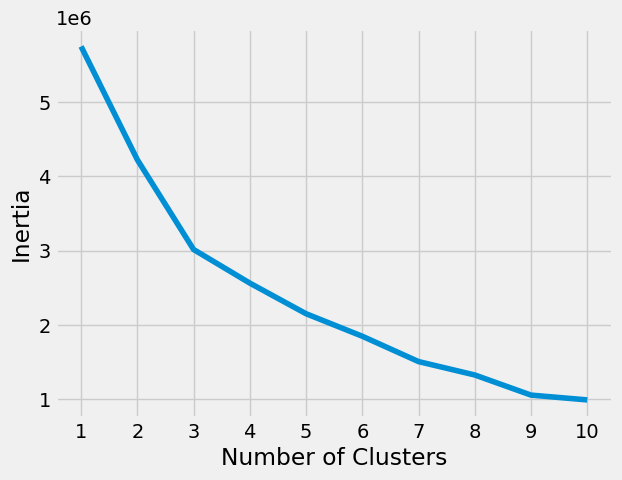

In [7]:

# visualisation of inertia
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), inertias)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [8]:

# evaluation
from sklearn.metrics import adjusted_rand_score, silhouette_score

kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
clusters = kmeans.fit_predict(df)

centers = kmeans.cluster_centers_

print()
print(centers)
print()



[[ 1.13716680e+00 -3.14589448e-02 -6.90298629e-02  3.06674271e+00
   3.13826092e+00  2.33291344e-01  4.86063552e-01  7.00814364e-03
  -3.24740235e-14  2.73636960e-01]
 [-7.09525156e-02 -2.01115074e-01 -1.99566398e-01 -2.02076701e-01
  -2.00798444e-01  1.73658837e-01  3.75783739e-01  6.73517044e-03
   3.65377458e-01  7.84447960e-02]
 [-8.87388671e-04  3.73172097e+00  3.74636866e+00  1.94778091e-01
   8.92353239e-02  9.97903351e-01  1.42490738e-04  8.26595736e-16
   6.51386231e-04  1.30277246e-03]]



In [10]:

"""
# silhouette score
silhouette_avg = silhouette_score(df, clusters)

print()
print(f"Silhouette Score: {silhouette_avg}")
print()
"""

# adjusted rand index
adjusted_rand_index = adjusted_rand_score(is_fraud, clusters)

print()
print(f"Adjusted Rand Index: {adjusted_rand_index}")
print()



Adjusted Rand Index: 0.0082222371221333

